# Watershed Dev

In [1]:
import importlib
import confocal
importlib.reload(confocal)

import glob, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import imageio
import re
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage.measurements import center_of_mass
from scipy.interpolate import interp2d,RegularGridInterpolator
from random import random
from tqdm import tqdm
from scipy.interpolate import interp1d

from itertools import accumulate
from skimage.measure import find_contours
from scipy.spatial import ConvexHull
import cv2

In [99]:

if True:
    cs1 = confocal.make_huvec26_obj(1)

if False:
    example_z = 10
    
    base_folder = 'datasets/20200724 AFM Test 3/HUVEC Cyto(g) Nucleus(b).export'
    
    objects_folder_base = base_folder # 'dataset/20200724 AFM Test 3/HUVEC Cyto(g) Nucleus(b).export'
#     objects_folder_base = 'datasets/HUVEC 3D Reconstruction Files/HUVEC Tubulin AD 0.7 ZStack Decon cellSens.export/'
    
    globular_full = os.path.join(base_folder, 'Intensity.png.export/Intensity_Z*.png') #'AFM Test 100x/AFM Oversampling - Deconvolution/Intensity.png.export/*.png'
    print('Raw png count:', globular_full, len(glob.glob(globular_full)))
    destdir = base_folder
    desc = 'reg'
    # 'index_re': r'_Z(\d+)',
    o = dict(
        globular_full=globular_full,
        # reuse segmentation
        globular_nucleus = os.path.join(objects_folder_base,'objects/Nucleus*.png'),
        globular_cyto = os.path.join(objects_folder_base,'objects/Cytoplasm*.png'),
        source_folder = base_folder, # diagnostics folder will be created here
        
        nuc_color=2,
        cyto_color=0,
        other_color=2,    
    )

    cs1 = confocal.gen_load(o)

    
print(cs1.data.keys())

dict_keys(['full_image', 'nucleus_mask', 'cyto_mask', 'source_folder', 'blue_linear2D', 'green_linear2D', 'red_linear2D', 'nucleus_linear_mask2D', 'cyto_linear_mask2D', 'cyto_linear3D', 'nucleus_linear3D', 'other_linear3D'])


slices is None


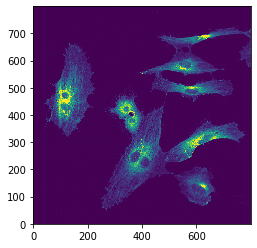

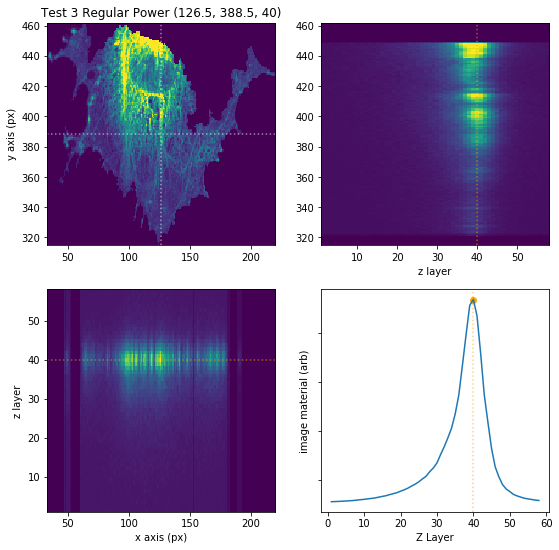

In [102]:
res = cs1.render_image('cyto_linear3D',sliced=40, series=False, do_plot=True)
cyto_id = 1

cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test', debug=False, series=False,
                   mask=cs1.data['cyto_linear_mask2D'][cyto_id])
cs1.four_panel('cyto_test',desc='Test 3 Regular Power', z=40)

plt.show()

# cs1.create_cropped('cyto_linear3D', cropped_name='green_test', debug=False, series=False, window=cs1.data['cyto_linear_mask2D'][cyto_id]['extent'])
# cs1.four_panel('cyto_test',desc='Test 3 Regular Power', z=10)

# plt.show()


  0%|          | 0/11 [00:00<?, ?it/s]

datasets/AFM-C HUVEC 20200626/diagnostic/
Cell: 1


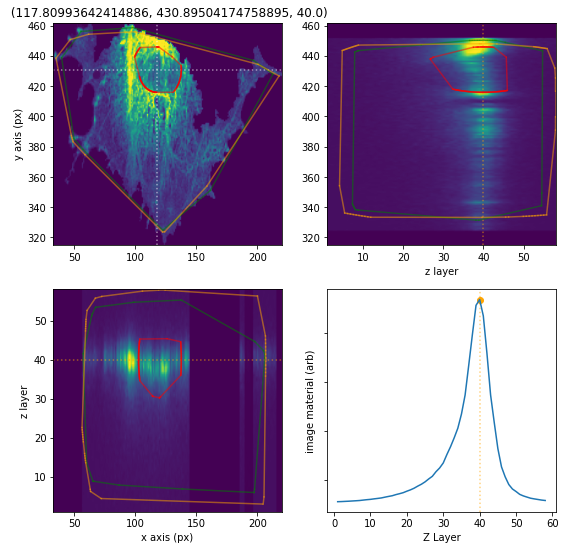

  9%|▉         | 1/11 [00:16<02:44, 16.46s/it]

Cell: 2


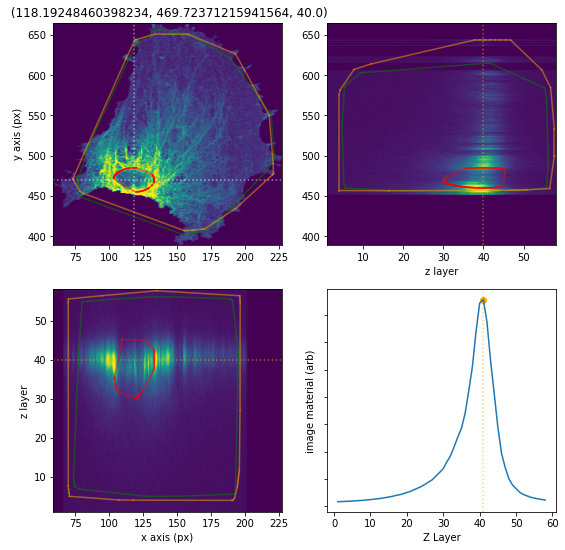

 18%|█▊        | 2/11 [00:37<02:41, 17.91s/it]

Cell: 3


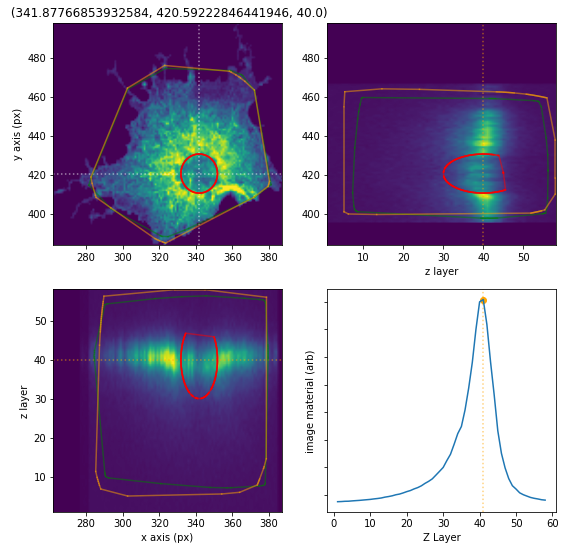

 27%|██▋       | 3/11 [00:52<02:16, 17.10s/it]

Cell: 4


 27%|██▋       | 3/11 [01:07<02:59, 22.41s/it]


KeyboardInterrupt: 

In [103]:
diagnostic_folder=os.path.join(cs1.data['source_folder'],'diagnostic/')
os.makedirs(diagnostic_folder,exist_ok=True)

print(diagnostic_folder)
# raise Exception()

for cyto_id in tqdm(cs1.data['cyto_linear_mask2D']):
#     cyto_id=1
    if True:
        cs1.create_cropped('cyto_linear3D', cropped_name='cyto_test_%02d' % cyto_id, debug=False, series=False,
                           mask=cs1.data['cyto_linear_mask2D'][cyto_id])
#         print('created ','green_test_%02d' % cyto_id)
        cs1.create_cropped('nucleus_linear3D', cropped_name='nucleus_test_%02d' % cyto_id, debug=False, series=False,
                           mask=cs1.data['cyto_linear_mask2D'][cyto_id])
        cs1.create_cropped('other_linear3D', cropped_name='other_test_%02d' % cyto_id, debug=False, series=False,
                   mask=cs1.data['cyto_linear_mask2D'][cyto_id])

        cs1.find_envelope3D('cyto_test_%02d' % cyto_id, 'cyto_test_env_%02d' % cyto_id, n_angle=320, max_r=200, n_r=201, pct=0.95)
        cs1.find_envelope3D('nucleus_test_%02d' % cyto_id, 'nucleus_test_env_%02d' % cyto_id, n_angle=320, max_r=200, pct=0.95)
        cs1.find_envelope3D('other_test_%02d' % cyto_id, 'other_test_env_%02d' % cyto_id, n_angle=320, max_r=200, pct=0.90)

    print('Cell:', cyto_id)
    save_four_to = os.path.join(diagnostic_folder,'four_z%02d' % cyto_id)
    cs1.four_panel('cyto_test_%02d' % cyto_id, envelopes=[
        {'target':'cyto_test_env_%02d' % cyto_id,'color':'green'},
        {'target':'other_test_env_%02d' % cyto_id,'color':'orange'}, 
        'nucleus_test_env_%02d' % cyto_id
    ], do_save=None,upscale=10, center_on='nucleus_test_%02d' % cyto_id, env_alpha=0.5)
    plt.show()
#     break

## Example from Documentation

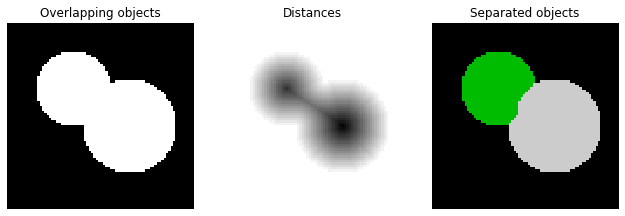

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()


## Segmenting the Nucleus

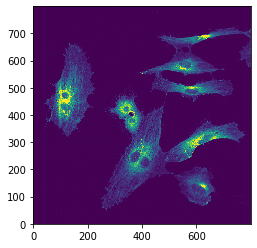

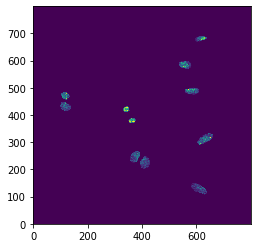

In [109]:
r = np.array(cs1.render_image('cyto_linear3D',sliced=40, do_plot=True))
plt.show()
n = cs1.render_image('nucleus_linear3D',sliced=40, do_plot=True)
plt.show()

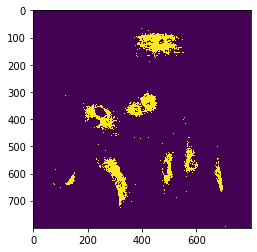

In [121]:
plt.imshow(r>100)

In [78]:
# from cellprofiler.modules import threshold

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

In [8]:
import sys
sys.executable

'/Users/asears/opt/anaconda3/bin/python'

In [9]:
import centrosome.propagate

(800, 800)


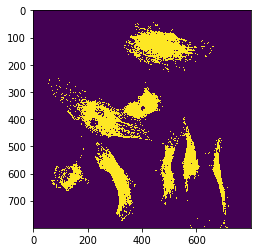

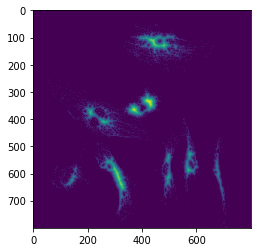

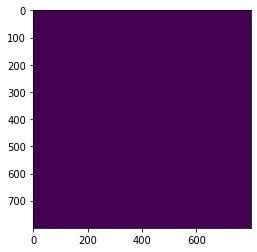

ValueError: operands could not be broadcast together with shapes (800,800) (80,80) 

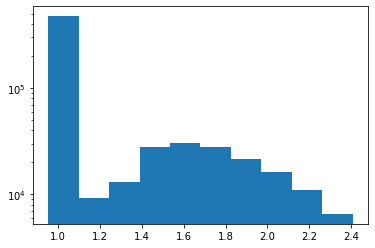

In [122]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max


t_image = np.where(r,r>50,0)
print(t_image.shape)
distance = ndi.distance_transform_edt(t_image)
plt.imshow(t_image)
plt.show()
plt.imshow(distance)
plt.show()
bg = np.where(1,r==0,1)
plt.imshow(bg)
plt.show()

if True:
    plt.hist(np.log10(r[r>0]), log=True)
    # plt.imshow(distance)
    # plt.hist(np.log10(np.hstack(r[r>0])), log=True)

    local_maxi = peak_local_max(distance, labels=image,
                                footprint=np.ones((3, 3)),
                                indices=False)
    markers = ndi.label(local_maxi)[0]



out: (800, 800) (800, 800)


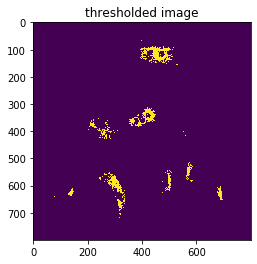

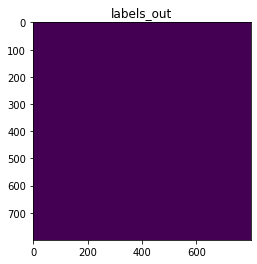

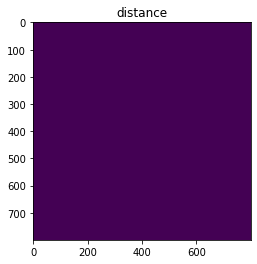

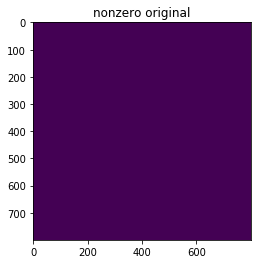

In [123]:
# labels_in:
    
#         labels_in = objects.unedited_segmented.copy()
#         labels_touching_edge = numpy.hstack(
#             (labels_in[0, :], labels_in[-1, :], labels_in[:, 0], labels_in[:, -1])
#         )
#         labels_touching_edge = numpy.unique(labels_touching_edge)
#         is_touching = numpy.zeros(numpy.max(labels_in) + 1, bool)
#         is_touching[labels_touching_edge] = True
#         is_touching = is_touching[labels_in]

#         labels_in[(~is_touching) & (objects.segmented == 0)] = 0

# thresholded image is a binarized starting guess?
# img = pixel_data. good.

labels_in = r>0
t_image = np.where(r,r>150,0)
thresholded_image = t_image

labels_out, distance = centrosome.propagate.propagate(
    r, labels_in, thresholded_image, 0.10)

#     image - gives the Z height when computing distance
#     labels - the labeled image pixels
#     mask   - only label pixels within the mask
#     weight - the weighting of x/y distance vs z distance
#              high numbers favor x/y, low favor z

print('out:', labels_out.shape, distance.shape)
plt.imshow(t_image)
plt.title('thresholded image')
plt.show()
plt.imshow(labels_out)
plt.title('labels_out')
plt.show()
plt.title('distance')
plt.imshow(distance)
plt.show()
plt.title('nonzero original')
plt.imshow(np.where(r,r>0,0))
plt.show()

import centrosome.cpmorphology

if True:
    if True:
        label_mask = labels_out == 0
        small_removed_segmented_out = centrosome.cpmorphology.fill_labeled_holes(
            labels_out, mask=label_mask
            )
    else:
        small_removed_segmented_out = labels_out.copy()
        segmented_out = self.filter_labels(
            small_removed_segmented_out, objects, workspace
            )

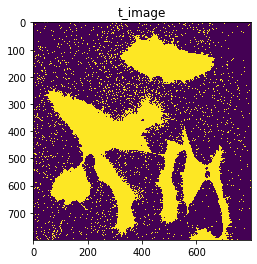

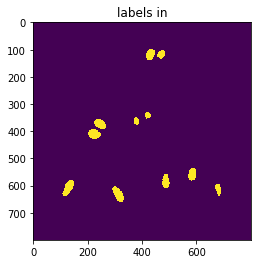

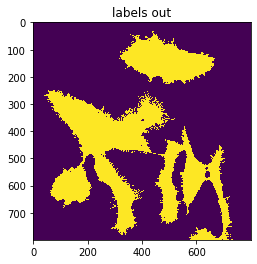

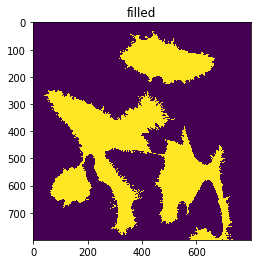

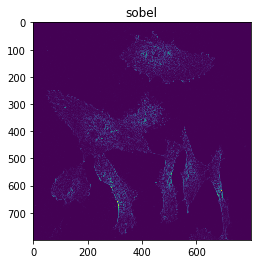

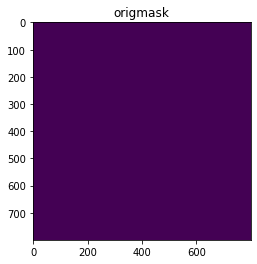

In [129]:
import scipy,skimage

labels_in = n>0 # r>10 # r>0

ret, t_image = cv2.threshold(r.astype('uint8'),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
t_image = (r>10) #~(r>250)

sobel_image = np.abs(scipy.ndimage.sobel(r))
#
# Combine the image mask and threshold to mask the watershed
#
watershed_mask = np.logical_or(t_image, labels_in > 0)
watershed_mask = np.logical_and(watershed_mask, np.where(r,r>0,0))

#
# Perform the first watershed
#

labels_out = skimage.morphology.watershed(
    connectivity= np.ones((3, 3), bool), # np.uint8
#     compactness=0.1,
    image=sobel_image,
    markers=labels_in,
    mask=watershed_mask,
)

if True:
    if True:
        label_mask = labels_out == 0
        small_removed_segmented_out = centrosome.cpmorphology.fill_labeled_holes(
            labels_out, mask=label_mask
        )
    else:
        small_removed_segmented_out = labels_out.copy()
   
plt.imshow(t_image)
plt.title('t_image')
plt.show()
plt.imshow(labels_in)
plt.title('labels in')
plt.show()
plt.imshow(labels_out)
plt.title('labels out')
plt.show()
plt.imshow(small_removed_segmented_out)
plt.title('filled')
plt.show()
plt.imshow(sobel_image)
plt.title('sobel')
plt.show()
plt.imshow(np.where(r,r>0,0))
plt.title('origmask')
plt.show()

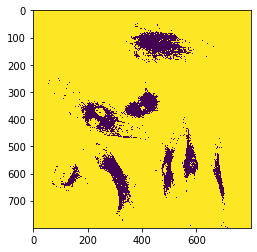

In [130]:
import cv2
ret, thresh = cv2.threshold(r.astype('uint8'),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh)

In [131]:
labels = watershed(-distance, markers, mask=image)
plt.imshow(labels)
all_l = set([])
# for l in labels:
#     all_l.update(l)
    
# # print(all_l)

ValueError: `mask` (shape (80, 80)) must have same shape as `image` (shape (800, 800))

In [27]:
labels_out, distances = centrosome.propagate.propagate(
                    img, labels_in, thresholded_image, 1.0)


NameError: name 'img' is not defined